# Imports and Setup

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import numpy as np
import seaborn as sns
import pickle
from google.colab import drive
import scipy.stats as stats
import json
import networkx as nx
import colorsys
import collections
from networkx.algorithms import community

In [ ]:
# Mount Google Drive in Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# List of months from 09/23 to 10/24 (as strings "YYYY-MM")
months = ["2023-09", "2023-10", "2023-11", "2023-12", "2024-01", "2024-02",
          "2024-03", "2024-04", "2024-05", "2024-06", "2024-07", "2024-08",
          "2024-09", "2024-10"]

# Set the directory where the JSON files are stored (in Google Drive)
data_dir = '/content/drive/My Drive/IsraelPalestine subreddit data/processed_data'
proccessed_data_dir = '/content/drive/My Drive/time_series_analysis'

# Path to your CSV file in your Drive.
csv_path = '/content/drive/My Drive/time_series_analysis/processed_contributions.csv'

# Submittions Data Analysis

In [ ]:
# Load the CSV file into a DataFrame.
df = pd.read_csv(csv_path)

# Convert the 'created_date' column to datetime.
df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')

# Filter for submissions only (assuming the column 'type' exists and is "submission" for posts).
df_submissions = df[df['type'] == 'submission']

# Group by the created_date and count the number of submissions per day.
daily_counts = df_submissions.groupby('created_date').size().reset_index(name='submission_count')

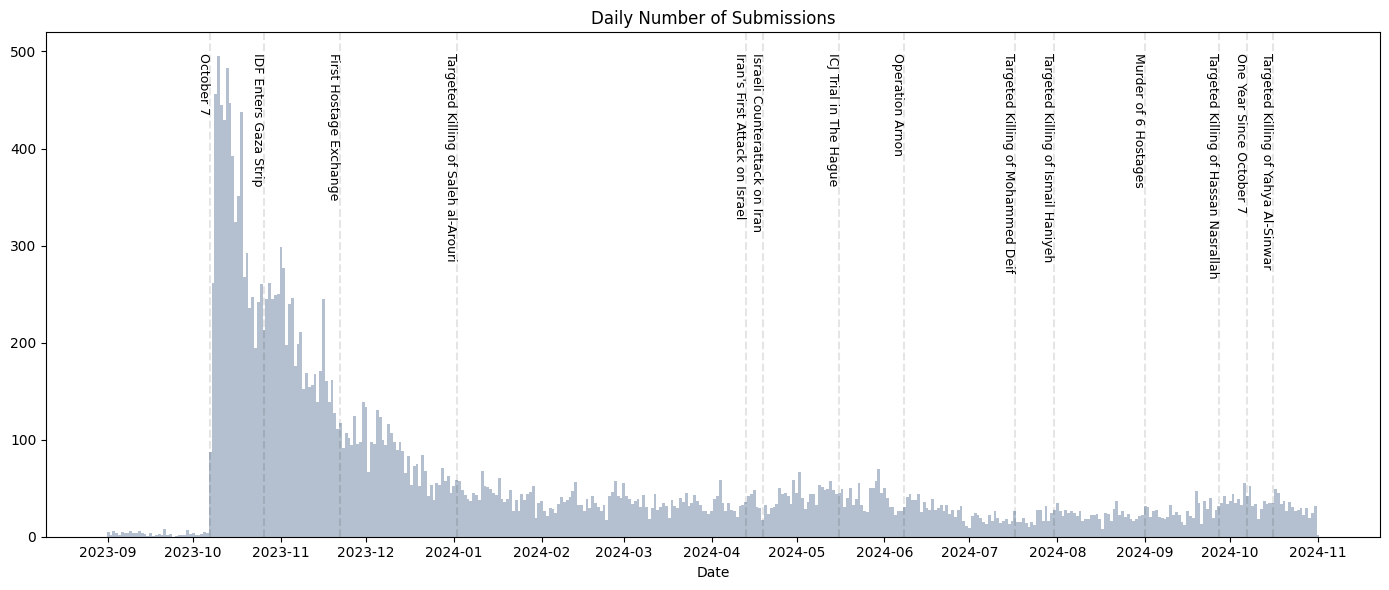

In [ ]:
# Plot the daily submission count.
plt.figure(figsize=(14,6))
plt.bar(daily_counts['created_date'], daily_counts['submission_count'], color='#b4c0cf', width=1.01) # '#88b4e3'
plt.xlabel('Date')
plt.title('Daily Number of Submissions')

# Set the x-axis to show ticks for every month.
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Define a dictionary with event dates and labels.
events = {
    datetime.datetime(2023, 10, 7): 'October 7',
    datetime.datetime(2023, 10, 26): 'IDF Enters Gaza Strip',
    datetime.datetime(2023, 11, 22): 'First Hostage Exchange',
    datetime.datetime(2024, 1, 2): 'Targeted Killing of Saleh al-Arouri',
    datetime.datetime(2024, 4, 13): "Iran's First Attack on Israel",
    datetime.datetime(2024, 4, 19): "Israeli Counterattack on Iran",
    datetime.datetime(2024, 5, 16): 'ICJ Trial in The Hague',
    datetime.datetime(2024, 6, 8): 'Operation Arnon',
    datetime.datetime(2024, 7, 17): 'Targeted Killing of Mohammed Deif',
    datetime.datetime(2024, 7, 31): 'Targeted Killing of Ismail Haniyeh',
    datetime.datetime(2024, 9, 1): 'Murder of 6 Hostages',
    datetime.datetime(2024, 9, 27): 'Targeted Killing of Hassan Nasrallah',
    datetime.datetime(2024, 10, 7): 'One Year Since October 7',
    datetime.datetime(2024, 10, 16): 'Targeted Killing of Yahya Al-Sinwar'
}

# Get the current y-axis limits to help position annotations inside the chart.
ymin, ymax = plt.ylim()
y_position = ymax * 0.95  # Position the label at 95% of the y-axis height.

# Loop over the events and annotate them on the plot.
for event_date, label in events.items():
    plt.axvline(event_date, color='black', linestyle='--', alpha=0.1)
    plt.annotate(label,
                 xy=(event_date, y_position),
                 xytext=(event_date, y_position),
                 rotation=270,
                 ha='right',
                 va='center_baseline',
                 fontsize=9)

# Adjust x-tick labels and formatting
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


### Ideology and Sentiment Analysis

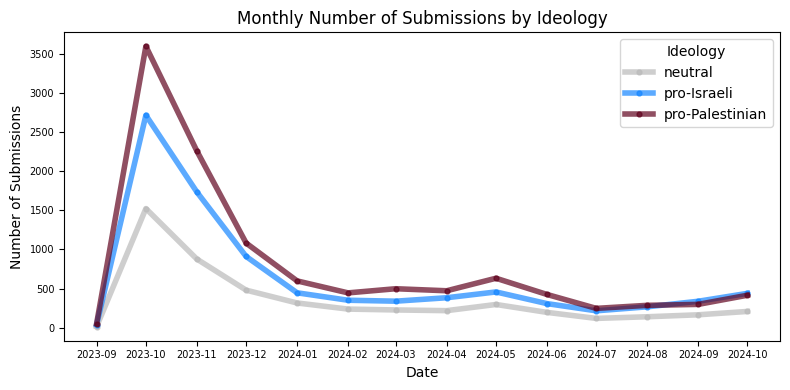

In [ ]:
# Convert the 'created_date' column to datetime.
df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')

# Filter for submissions.
df_submissions = df[df['type'] == 'submission']

# Set the desired end date manually.
end_date = pd.to_datetime("2024-10-01")

# Optionally, filter out submissions beyond the desired month.
df_submissions = df_submissions[df_submissions['created_date'] < end_date + pd.DateOffset(months=1)]

# Group by ideology and month (using the start of each month).
grouped_month = df_submissions.groupby(['ideology', pd.Grouper(key='created_date', freq='MS')]) \
                              .size().reset_index(name='submission_count')

# Pivot the data so that each ideology becomes a separate column.
pivot = grouped_month.pivot(index='created_date', columns='ideology', values='submission_count')

# Create a complete monthly date range using month-start frequency.
monthly_range = pd.date_range(start=df_submissions['created_date'].min(),
                              end=end_date, freq='MS')

# Reindex the pivoted data to include every month, filling missing values with 0.
pivot = pivot.reindex(monthly_range, fill_value=0)
pivot.index.name = 'created_date'
pivot = pivot.reset_index()

# Plot the monthly submission count as a line plot with a line for each ideology.
plt.figure(figsize=(8,4))

# Define colors for each ideology.
colors = {
    'pro-Israeli': '#1787ff',
    'neutral': '#bababa',
    'pro-Palestinian': '#610520'
}

# Plot each ideology's line with its specified color.
for ideology in pivot.columns[1:]:
    plt.plot(pivot['created_date'], pivot[ideology], marker = '.', markersize=7,
             linestyle='-', linewidth=4, alpha=0.7,
             color=colors.get(ideology, None),  # Use a default color if the ideology isn't in our mapping.
             label=ideology)

plt.xlabel('Date')
plt.ylabel('Number of Submissions')
plt.title('Monthly Number of Submissions by Ideology')

# Set the x-axis to show ticks for every month.
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate x-axis labels and adjust font size.
plt.xticks(rotation=0, fontsize=7)
plt.yticks(fontsize=7)

# Display a legend to differentiate the ideologies.
plt.legend(title='Ideology')

plt.tight_layout()
plt.show()


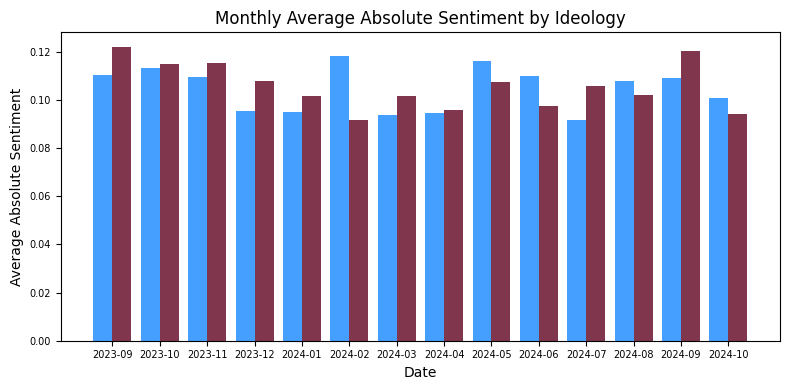

In [ ]:
# Load the DataFrame.
df = pd.read_csv(csv_path)

# Convert 'created_date' to datetime.
df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')

# Filter for submissions.
df_submissions = df[df['type'] == 'submission']

# Optionally, exclude "neutral" ideology from the sentiment analysis.
df_submissions = df_submissions[df_submissions['ideology'] != 'neutral']

# Compute the absolute sentiment.
# (Using absolute sentiment captures intensity regardless of whether it's positive or negative.
#  Alternatively, you could compute the average sentiment to see net polarity.)
df_submissions['abs_sentiment'] = df_submissions['sentiment'].abs()

# Set the desired end date to October 2024.
end_date = pd.to_datetime("2024-10-01")

# Filter out submissions beyond October 2024.
df_submissions = df_submissions[df_submissions['created_date'] < end_date + pd.DateOffset(months=1)]

# ----------------------
# Compute Monthly Average Absolute Sentiment (by ideology)
# ----------------------
grouped_sent = df_submissions.groupby(
    ['ideology', pd.Grouper(key='created_date', freq='MS')]
)['abs_sentiment'].mean().reset_index(name='avg_abs_sentiment')

# Pivot the sentiment data so each ideology becomes its own column.
pivot_sent = grouped_sent.pivot(index='created_date', columns='ideology', values='avg_abs_sentiment')

# Create a complete monthly date range using month-start frequency.
monthly_range = pd.date_range(start=df_submissions['created_date'].min(), end=end_date, freq='MS')

# Reindex the pivot table to ensure every month is present; fill missing values with 0.
pivot_sent = pivot_sent.reindex(monthly_range, fill_value=0)
pivot_sent.index.name = 'created_date'
pivot_sent = pivot_sent.reset_index()

# ----------------------
# Plotting as Grouped Bar Plot
# ----------------------
plt.figure(figsize=(8,4))

# Define colors for each ideology.
colors = {
    'pro-Israeli': '#1787ff',
    'pro-Palestinian': '#610520'
}

# Get list of ideologies (now only "pro-Israeli" and "pro-Palestinian").
ideologies = [col for col in pivot_sent.columns if col != 'created_date']
n = len(ideologies)

# Set total width for each group of bars at one x-tick and calculate individual bar width.
total_width = 0.8
bar_width = total_width / n

# Create x locations for each month.
x = range(len(pivot_sent))

# Plot bars for each ideology with an appropriate offset.
for i, ideology in enumerate(ideologies):
    offset = (i - n/2) * bar_width + bar_width/2  # centers the bars around the tick
    plt.bar([p + offset for p in x],
            pivot_sent[ideology],
            width=bar_width,
            color=colors.get(ideology, None),
            alpha=0.8,
            label=ideology)

# Set x-tick positions and labels.
plt.xticks(ticks=x, labels=[d.strftime('%Y-%m') for d in pivot_sent['created_date']], rotation=0, fontsize=7)
plt.yticks(fontsize=7)

plt.xlabel('Date')
plt.ylabel('Average Absolute Sentiment')
plt.title('Monthly Average Absolute Sentiment by Ideology')
# plt.legend(title='Ideology')
# plt.legend(title='Ideology', loc='upper right', fontsize=7, title_fontsize=9) #, frameon=False)
plt.tight_layout()
plt.show()


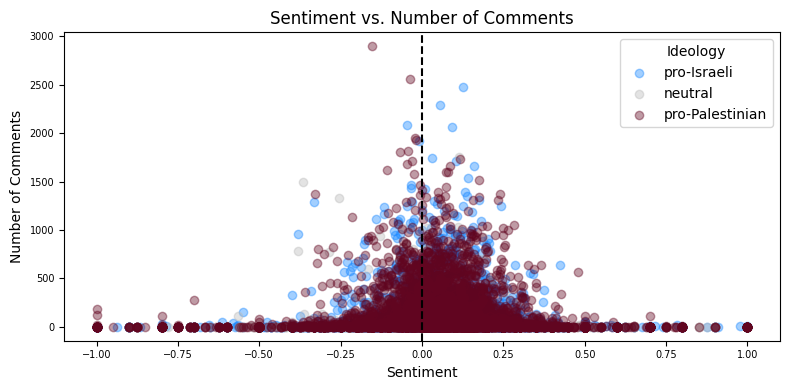

In [ ]:
# Load the dataset (make sure csv_path is defined)
df = pd.read_csv(csv_path)

# Convert 'created_date' to datetime and create a 'month' column in "YYYY-MM" format
df['created_date'] = pd.to_datetime(df['created_date'])
df['month'] = df['created_date'].dt.to_period('M').astype(str)

# Define colors for each ideology
colors = {
    'pro-Israeli': '#1787ff',
    'neutral': '#bababa',
    'pro-Palestinian': '#610520'
}

# Create the scatter plot (no need for ax1)
plt.figure(figsize=(8, 4))

for ideology, color in colors.items():
    subset = df[df['ideology'] == ideology]
    plt.scatter(
        subset['sentiment'],
        subset['num_comments'],
        color=color,
        alpha=0.4,
        label=ideology
    )

# Add a vertical dashed line at sentiment = 0
plt.axvline(x=0.0, color='black', linestyle='--')

# Axis labels and ticks
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# Legend and title
plt.legend(title='Ideology', loc='upper right')
plt.title('Sentiment vs. Number of Comments')

plt.tight_layout()
plt.show()


In [ ]:
# Load the dataset (make sure csv_path is defined)
df = pd.read_csv(csv_path)

# Extract the sentiment data
sentiment_data = df['sentiment']

# Calculate the mean (μ) and standard deviation (σ) from the sentiment data
mu, std = sentiment_data.mean(), sentiment_data.std()

# Perform the Kolmogorov-Smirnov test
# The test compares the data to a normal distribution with parameters mu and std.
statistic, p_value = stats.kstest(sentiment_data, 'norm', args=(mu, std))

print("Kolmogorov-Smirnov test statistic:", statistic)
print("p-value:", p_value)


Kolmogorov-Smirnov test statistic: 0.22475084361533262
p-value: 0.0


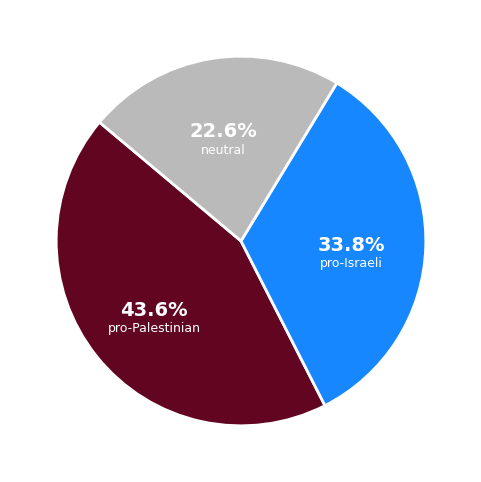

In [ ]:
# Custom function to format labels inside slices
def label_format(pct):
    return f"{pct:.1f}%"  # Show percentage only

# Create Pie Chart
plt.figure(figsize=(4, 4))
wedges, texts, autotexts = plt.pie(
    user_counts,
    labels=None,  # Hide default labels
    autopct=lambda pct: "",  # Empty autopct (we set text manually)
    colors=pie_colors,
    startangle=140,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}  # White edges
)

# Manually add text inside slices with different font sizes
for i, wedge in enumerate(wedges):
    # Get the center of each wedge
    angle = (wedge.theta2 + wedge.theta1) / 2  # Midpoint angle
    x = np.cos(np.radians(angle)) * 0.6  # Adjust x position
    y = np.sin(np.radians(angle)) * 0.6  # Adjust y position

    # Add percentage (large text)
    plt.text(x, y, f"{user_counts.iloc[i]:.1f}%",
             ha='center', va='center', fontsize=14, fontweight='bold', color='white')

    # Add group name (small text, positioned slightly lower)
    plt.text(x, y - 0.1, user_counts.index[i],
             ha='center', va='center', fontsize=9, color='white')

# Set Title
# plt.title('Proportion of Users Ideology', size = 12)

plt.show()


In [ ]:
# Assuming df is already loaded from your CSV file

# 1) Summary Statistics for Score by Ideology
score_stats = df.groupby('ideology')['score'].agg(['mean', 'std', 'count']).reset_index()
score_stats['mean'] = score_stats['mean'].round(2)
score_stats['std'] = score_stats['std'].round(2)
print("Summary Statistics for Score by Ideology:")
print(score_stats)

# 2) Summary Statistics for Upvote Ratio by Ideology
upvote_stats = df.groupby('ideology')['upvote_ratio'].agg(['mean', 'std', 'count']).reset_index()
upvote_stats['mean'] = upvote_stats['mean'].round(2)
upvote_stats['std'] = upvote_stats['std'].round(2)
print("\nSummary Statistics for Upvote Ratio by Ideology:")
print(upvote_stats)

# 3) Summary Statistics for Number of Comments by Ideology
comments_stats = df.groupby('ideology')['num_comments'].agg(['mean', 'std', 'count']).reset_index()
comments_stats['mean'] = comments_stats['mean'].round(2)
comments_stats['std'] = comments_stats['std'].round(2)
print("\nSummary Statistics for Number of Comments by Ideology:")
print(comments_stats)


Summary Statistics for Score by Ideology:
          ideology   mean    std  count
0          neutral   3.72  17.50   5017
1      pro-Israeli   8.27  32.59   8942
2  pro-Palestinian  10.20  35.31  11299

Summary Statistics for Upvote Ratio by Ideology:
          ideology  mean   std  count
0          neutral  0.94  0.16   5017
1      pro-Israeli  0.85  0.24   8942
2  pro-Palestinian  0.88  0.21  11299

Summary Statistics for Number of Comments by Ideology:
          ideology   mean     std  count
0          neutral  21.27   88.82   5017
1      pro-Israeli  62.05  156.27   8942
2  pro-Palestinian  66.78  168.93  11299


In [ ]:
# submission with the highest score:
pro_israeli_max = df.sort_values('score', ascending=False).iloc[0]
print("Submission with the highest score")
print(pro_israeli_max)
print("\nFull Text:")
print(pro_israeli_max['text'])
print("\n" + "-"*80 + "\n")


Submission with the highest score
id                                                           1db0mfe
author                                              CreativeRealmsMC
author_fullname                                             t2_g06f9
type                                                      submission
text               Four Hostages Rescued From Gaza Noa Argamani (...
ideology                                                 pro-Israeli
sentiment                                                      0.125
created_date                                     2024-06-08 00:00:00
score                                                           1309
num_comments                                                    2475
upvote_ratio                                                    0.87
month                                                        2024-06
Name: 21429, dtype: object

Full Text:
Four Hostages Rescued From Gaza Noa Argamani (25), Almog Meir Jan (21), Andrey Kozlov (27), and Shl

# Social Network Analysis

In [ ]:
# Edges Explanation:
# In this network, an edge is created between two users when one user comments on a submission made by the other.
# The edge's 'weight' attribute represents the number of times such an interaction has occurred.
# Therefore, a higher weight means more frequent interactions (or responses) between the two users.
# This can be interpreted as a stronger or more active communication/response relationship.

### One month analysis

In [ ]:
def get_network_statistics_per_month(month):
    # --- Step 1: Load the preprocessed graph (nodes only) from pickle ---
    graph_path = f'/content/drive/My Drive/time_series_analysis/social_network_{month}.gpickle'
    with open(graph_path, 'rb') as f:
        G = pickle.load(f)

    # --- Step 2: Load the user activity JSON (which includes submissions and comments) ---
    activity_path = f'/content/drive/My Drive/IsraelPalestine subreddit data/processed_data/IsraelPalestine_{month}_user_activity.json'
    with open(activity_path, 'r') as f:
        user_activity = json.load(f)

    # --- Step 3: Add graph edges ---
    # Build a mapping from submission ID to its author.
    submission_to_author = {}
    for user, activities in user_activity.items():
        for sub in activities.get("submissions", []):
            sub_id = sub.get("id")
            if sub_id:
                submission_to_author[sub_id] = user

    # Add edges based on comments. Each time a user comments on a submission (identified by its submission_id),
    # we add (or increment) an edge between the comment's author and the submission's author.
    for user, activities in user_activity.items():
        for comment in activities.get("comments", []):
            sub_id = comment.get("submission_id")
            if sub_id and sub_id in submission_to_author:
                original_author = submission_to_author[sub_id]
                # Avoid self-loops.
                if original_author != user:
                    if G.has_edge(user, original_author):
                        G[user][original_author]["weight"] += 1
                    else:
                        G.add_edge(user, original_author, weight=1)

    # --- Print Basic Graph Stats ---
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    print("Number of nodes:", num_nodes)
    print("Number of edges:", num_edges)

    # --- Additional Network Statistics ---
    # Average (unweighted) degree
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    print(f"\nAverage degree (unweighted): {avg_degree:.3f}")

    # Average weighted degree
    avg_weighted_degree = sum(dict(G.degree(weight='weight')).values()) / num_nodes
    print(f"Average weighted degree: {avg_weighted_degree:.3f}")

    # Find the highest weight edge (i.e., most interactions between 2 people)
    max_weight = 0
    max_edge = None
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)
        if weight > max_weight:
            max_weight = weight
            max_edge = (u, v)
    print(f"\nHighest weight edge: {max_weight:.3f}")

    # Graph density
    density = nx.density(G)
    print(f"\nGraph density: {density:.3f}")

    # Connected components
    components = list(nx.connected_components(G))
    num_components = len(components)
    largest_component = max(components, key=len)
    print(f"Number of connected components: {num_components}")
    print(f"Size of largest connected component: {len(largest_component)}")

    # Average clustering coefficient (using edge weights if available)
    avg_clustering = nx.average_clustering(G, weight='weight')
    print(f"Average clustering coefficient: {avg_clustering:.3f}")

    # --- Ideology Percentages ---
    ideology_counts = collections.Counter([G.nodes[node].get('ideology', 'unknown') for node in G.nodes()])
    print("\nIdeology Percentages:")
    for ideology in ['pro-Israeli', 'pro-Palestinian', 'neutral']:
        count = ideology_counts.get(ideology, 0)
        percentage = (count / num_nodes) * 100
        print(f"{ideology}: {percentage:.3f}%")

    # --- Community Detection Using Edge Weights & Ideology Distribution ---
    all_communities = list(community.greedy_modularity_communities(G, weight='weight'))
    print(f"\nDetected {len(all_communities)} communities (using edge weights).")

    # Limit to top N communities (by size) if desired
    max_comms = 5  # for example, show only top 5 communities
    top_communities = sorted(all_communities, key=lambda c: len(c), reverse=True)[:max_comms]

    ratio_list = []

    for i, comm in enumerate(top_communities):
        ideology_counts = {}
        for node in comm:
            ideology = G.nodes[node].get('ideology', 'unknown')
            ideology_counts[ideology] = ideology_counts.get(ideology, 0) + 1
        # Calculate ratio for pro-Israeli to pro-Palestinian
        pro_israeli = ideology_counts.get('pro-Israeli', 0)
        pro_palestinian = ideology_counts.get('pro-Palestinian', 0)
        if pro_palestinian > 0:
            ratio = pro_israeli / pro_palestinian
            ratio_list.append(ratio)

    print(f"Avarage ratio pro_israeli:pro_palestinian for the top 5 comunities: {sum(ratio_list)/max_comms}")

    return G  # graph with edges

In [ ]:
def visualize_network(G, month):

    # Calculate the weighted degrees as a numpy array (for filtering)
    weighted_degree_dict = dict(G.degree(weight='weight'))
    all_degrees = np.array(list(weighted_degree_dict.values()))

    # Compute the 95th percentile threshold (top 5% nodes)
    threshold = np.percentile(all_degrees, 95)
    print("Weighted degree 95th percentile threshold:", threshold)

    # Filter out nodes: keep only those with weighted degree >= threshold
    filtered_nodes = [node for node, wd in weighted_degree_dict.items() if wd >= threshold]
    G_filtered = G.subgraph(filtered_nodes).copy()
    print("Filtered graph (top 5% nodes): Number of nodes:", G_filtered.number_of_nodes(),
          "Number of edges:", G_filtered.number_of_edges())

    # Visualize the filtered graph
    pos = nx.spring_layout(G_filtered, seed=42)
    # Here, we use the regular (unweighted) degree to set node sizes.
    node_sizes = [G_filtered.degree(node) * 3 for node in G_filtered.nodes()]

    # Define base colors for ideology
    base_colors = {
        'pro-Israeli': '#1787ff',
        'neutral': '#bababa',
        'pro-Palestinian': '#610520'
    }
    node_colors = []
    for node in G_filtered.nodes():
        ideology = G_filtered.nodes[node].get('ideology', 'neutral')
        node_colors.append(base_colors.get(ideology, '#bababa'))

    # Compute edge widths based on weight (using a multiplier, e.g., 0.1)
    edge_widths = [G_filtered[u][v]['weight'] * 0.05 for u, v in G_filtered.edges()]

    # Top 5% nodes by weighted degree, node size by regular degree
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(G_filtered, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
    nx.draw_networkx_edges(G_filtered, pos, width=edge_widths, alpha=0.5)
    plt.title(f"{month}", fontsize = 12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### Helper Functions

In [ ]:
def get_network_statistics_per_month_with_stats(month):
    # --- Step 1: Load the preprocessed graph (nodes only) from pickle ---
    graph_path = f'/content/drive/My Drive/time_series_analysis/social_network_{month}.gpickle'
    with open(graph_path, 'rb') as f:
        G = pickle.load(f)

    # --- Step 2: Load the user activity JSON (submissions and comments) ---
    activity_path = f'/content/drive/My Drive/IsraelPalestine subreddit data/processed_data/IsraelPalestine_{month}_user_activity.json'
    with open(activity_path, 'r') as f:
        user_activity = json.load(f)

    # --- Step 3: Add graph edges ---
    submission_to_author = {}
    for user, activities in user_activity.items():
        for sub in activities.get("submissions", []):
            sub_id = sub.get("id")
            if sub_id:
                submission_to_author[sub_id] = user

    for user, activities in user_activity.items():
        for comment in activities.get("comments", []):
            sub_id = comment.get("submission_id")
            if sub_id and sub_id in submission_to_author:
                original_author = submission_to_author[sub_id]
                # Avoid self-loops.
                if original_author != user:
                    if G.has_edge(user, original_author):
                        G[user][original_author]["weight"] += 1
                    else:
                        G.add_edge(user, original_author, weight=1)

    # --- Compute Graph Statistics ---
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    avg_weighted_degree = sum(dict(G.degree(weight='weight')).values()) / num_nodes

    max_weight = 0
    max_edge = None
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)
        if weight > max_weight:
            max_weight = weight
            max_edge = (u, v)

    density = nx.density(G)

    components = list(nx.connected_components(G))
    num_components = len(components)
    largest_component = max(components, key=len)

    avg_clustering = nx.average_clustering(G, weight='weight')

    # --- Ideology Percentages ---
    ideology_counts = collections.Counter(
        [G.nodes[node].get('ideology', 'unknown') for node in G.nodes()]
    )
    pro_israeli_pct = (ideology_counts.get('pro-Israeli', 0) / num_nodes) * 100
    pro_palestinian_pct = (ideology_counts.get('pro-Palestinian', 0) / num_nodes) * 100
    neutral_pct = (ideology_counts.get('neutral', 0) / num_nodes) * 100

    # --- Community Detection and Ratio Calculation ---
    all_communities = list(community.greedy_modularity_communities(G, weight='weight'))
    num_communities = len(all_communities)
    max_comms = 5
    top_communities = sorted(all_communities, key=lambda c: len(c), reverse=True)[:max_comms]
    ratio_list = []
    for comm in top_communities:
        ideology_counts_comm = {}
        for node in comm:
            ideology = G.nodes[node].get('ideology', 'unknown')
            ideology_counts_comm[ideology] = ideology_counts_comm.get(ideology, 0) + 1
        pro_israeli = ideology_counts_comm.get('pro-Israeli', 0)
        pro_palestinian = ideology_counts_comm.get('pro-Palestinian', 0)
        if pro_palestinian > 0:
            ratio_list.append(pro_israeli / pro_palestinian)
    avg_ratio = sum(ratio_list) / len(ratio_list) if ratio_list else None

    # --- Pack Statistics into a Dictionary ---
    stats = {
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'avg_degree': avg_degree,
        'avg_weighted_degree': avg_weighted_degree,
        'max_weight': max_weight,
        'graph_density': density,
        'num_connected_components': num_components,
        'largest_connected_component_size': len(largest_component),
        'avg_clustering': avg_clustering,
        'pro_israeli_percentage': pro_israeli_pct,
        'pro_palestinian_percentage': pro_palestinian_pct,
        'neutral_percentage': neutral_pct,
        'num_communities': num_communities,
        'avg_ratio_pro_israeli_to_pro_palestinian': avg_ratio
    }

    return G, stats

def run_all_months(months):
    """
    For each month in the list:
      1) Runs the network statistics code.
      2) Stores the graph in a dictionary (month -> graph).
      3) Collects the calculated stats in a DataFrame.
    Returns:
      graphs: dict mapping month to graph (G)
      df_stats: DataFrame with month as rows and various statistics as columns.
    """
    graphs = {}
    stats_list = []
    for month in months:
        G, stats = get_network_statistics_per_month_with_stats(month)
        graphs[month] = G
        stats['month'] = month  # so we can index later
        stats_list.append(stats)
    df_stats = pd.DataFrame(stats_list)
    df_stats.set_index('month', inplace=True)
    return graphs, df_stats

# graphs_dict is a dictionary with keys as month strings and values as graphs,
# and stats_df is a DataFrame where each row corresponds to a month and the columns hold the computed attributes.

In [ ]:
def visualize_network_on_ax(ax, G, month):
    # Calculate the weighted degrees as a numpy array (for filtering)
    weighted_degree_dict = dict(G.degree(weight='weight'))
    all_degrees = np.array(list(weighted_degree_dict.values()))

    # Compute the 95th percentile threshold (top 5% nodes)
    threshold = np.percentile(all_degrees, 99)
    print(f"[{month}] Weighted degree 99th percentile threshold:", threshold)

    # Filter out nodes: keep only those with weighted degree >= threshold
    filtered_nodes = [node for node, wd in weighted_degree_dict.items() if wd >= threshold]
    G_filtered = G.subgraph(filtered_nodes).copy()
    print(f"[{month}] Filtered graph: Number of nodes:", G_filtered.number_of_nodes(),
          "Number of edges:", G_filtered.number_of_edges())

    # Generate layout
    pos = nx.spring_layout(G_filtered, seed=42)

    # Node sizes based on regular degree
    node_sizes = [G_filtered.degree(node) * 3 for node in G_filtered.nodes()]

    # Define base colors for ideology
    base_colors = {
        'pro-Israeli': '#1787ff',
        'neutral': '#bababa',
        'pro-Palestinian': '#610520'
    }
    node_colors = [
        base_colors.get(G_filtered.nodes[node].get('ideology', 'neutral'), '#bababa')
        for node in G_filtered.nodes()
    ]

    # Compute edge widths based on weight
    edge_widths = [G_filtered[u][v]['weight'] * 0.05 for u, v in G_filtered.edges()]

    # Draw nodes and edges on the provided axis
    nx.draw_networkx_nodes(G_filtered, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(G_filtered, pos, width=edge_widths, alpha=0.5, ax=ax)

    # Set the subplot title with the month and remove axis
    ax.set_title(month, fontsize=16)
    ax.axis('off')

def visualize_all_networks(graphs_dict):
    """
    Visualizes all networks in a 2x7 grid layout.
    Each subplot corresponds to one month from the graphs_dict.
    """
    # Create a 2x7 grid of subplots
    fig, axes = plt.subplots(2, 7, figsize=(24, 8))
    axes = axes.flatten()  # Flatten the 2D array for easy iteration

    # Loop over each month and its corresponding graph
    for ax, (month, G) in zip(axes, graphs_dict.items()):
        visualize_network_on_ax(ax, G, month)

    # Set overall title for the figure
    fig.suptitle("Top 1% nodes by weighted degree", fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for the suptitle
    plt.show()

### Build Networks and Get Statistics

In [ ]:
months = ["2023-09", "2023-10", "2023-11", "2023-12",
          "2024-01", "2024-02", "2024-03", "2024-04",
          "2024-05", "2024-06", "2024-07", "2024-08",
          "2024-09", "2024-10"]

graphs_dict, stats_df = run_all_months(months)

[2023-09] Weighted degree 99th percentile threshold: 239.49999999999955
[2023-09] Filtered graph: Number of nodes: 6 Number of edges: 10
[2023-10] Weighted degree 99th percentile threshold: 354.8899999999994
[2023-10] Filtered graph: Number of nodes: 264 Number of edges: 5119
[2023-11] Weighted degree 99th percentile threshold: 617.0499999999993
[2023-11] Filtered graph: Number of nodes: 151 Number of edges: 2197
[2023-12] Weighted degree 99th percentile threshold: 593.0
[2023-12] Filtered graph: Number of nodes: 96 Number of edges: 1216
[2024-01] Weighted degree 99th percentile threshold: 502.79999999999745
[2024-01] Filtered graph: Number of nodes: 63 Number of edges: 583
[2024-02] Weighted degree 99th percentile threshold: 507.47999999999956
[2024-02] Filtered graph: Number of nodes: 55 Number of edges: 450
[2024-03] Weighted degree 99th percentile threshold: 449.8200000000015
[2024-03] Filtered graph: Number of nodes: 59 Number of edges: 367
[2024-04] Weighted degree 99th percentil

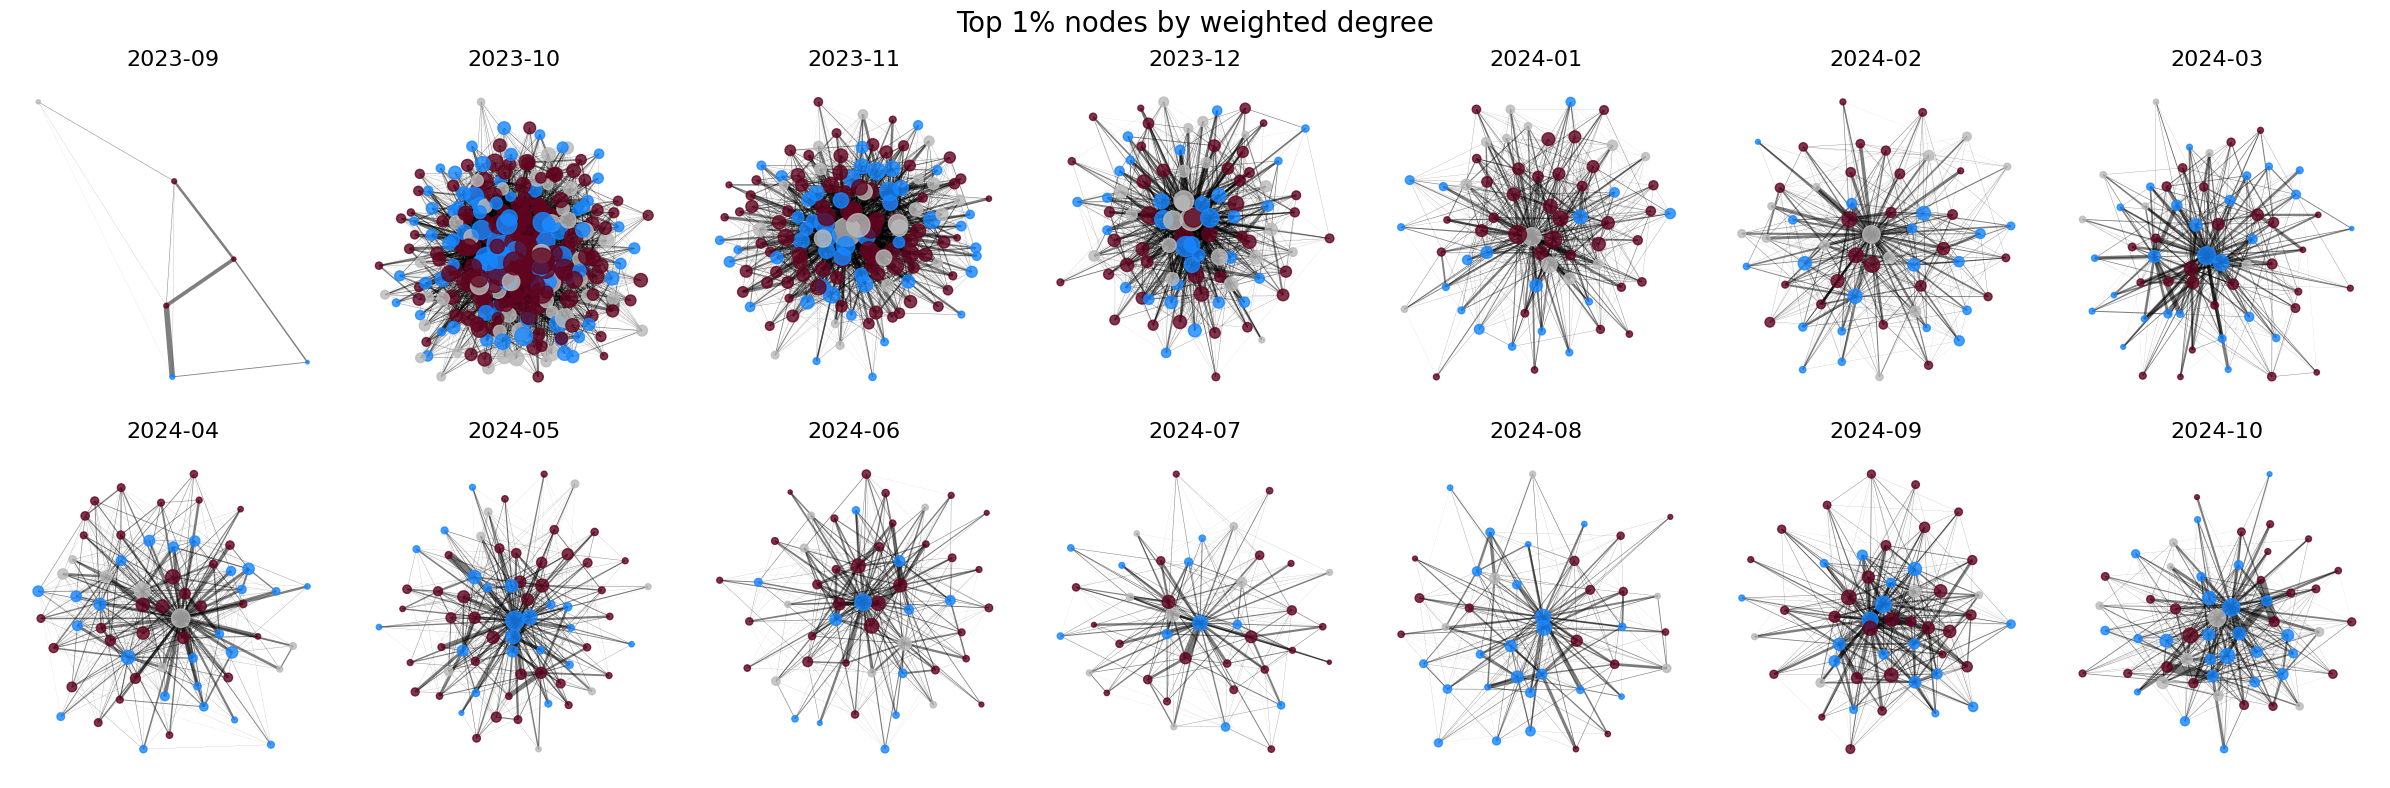

In [ ]:
visualize_all_networks(graphs_dict)

In [ ]:
stats_df

,num_nodes,num_edges,avg_degree,avg_weighted_degree,max_weight,graph_density,num_connected_components,largest_connected_component_size,avg_clustering,pro_israeli_percentage,pro_palestinian_percentage,neutral_percentage,num_communities,avg_ratio_pro_israeli_to_pro_palestinian
month,,,,,,,,,,,,,,
2023-09,599,1913,6.387312,24.043406,147,0.010681,9,591,0.001848,47.579299,34.223706,18.196995,16,1.465710
2023-10,26312,102577,7.796975,21.875114,237,0.000296,379,25932,0.000615,35.155062,38.818790,26.026148,398,0.904637
2023-11,15096,89767,11.892819,37.442104,141,0.000788,103,14993,0.001487,37.844462,39.884738,22.270800,122,0.924438
2023-12,9461,46903,9.915020,33.099884,167,0.001048,39,9422,0.001439,39.625832,39.107917,21.266251,57,1.012021
2024-01,6245,25444,8.148599,25.941713,100,0.001305,31,6215,0.002002,39.855885,37.822258,22.321857,54,1.110531
2024-02,5485,21329,7.777211,26.691705,95,0.001418,31,5455,0.002250,40.765725,36.955333,22.278943,51,1.058084
2024-03,5804,21445,7.389731,25.808753,141,0.001273,31,5773,0.001411,39.748449,38.094418,22.157133,48,1.072625
2024-04,6154,22590,7.341566,26.412740,85,0.001193,28,6127,0.002969,41.810205,35.407865,22.781930,46,1.270657
2024-05,6519,27936,8.570640,29.552692,140,0.001315,33,6487,0.001214,38.763614,39.039730,22.196656,51,0.908410


In [ ]:
# Save stats_df to a CSV file in the current working directory.
stats_df.to_csv("stats_df.csv", index=True)

### Plot Statistics

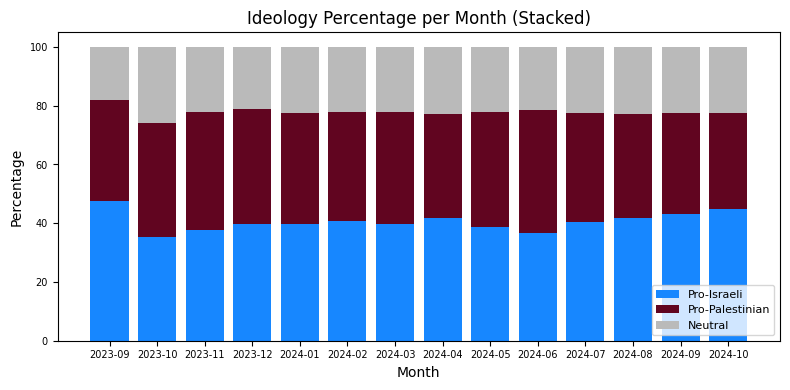

In [ ]:
# Assuming df_stats is your DataFrame with the percentage columns and month as index
pro_israeli = stats_df['pro_israeli_percentage']
pro_palestinian = stats_df['pro_palestinian_percentage']
neutral = stats_df['neutral_percentage']

plt.figure(figsize=(8, 4))
bar_width = 0.8  # adjust to make the bars thicker

# Plot the segments as stacked bars using x positions
plt.bar(x, pro_israeli, width=bar_width, label='Pro-Israeli', color='#1787ff')
plt.bar(x, pro_palestinian, width=bar_width, bottom=pro_israeli, label='Pro-Palestinian', color='#610520')
plt.bar(x, neutral, width=bar_width, bottom=pro_israeli + pro_palestinian, label='Neutral', color='#bababa')

plt.xlabel('Month')
plt.ylabel('Percentage')
plt.title('Ideology Percentage per Month (Stacked)')
plt.xticks(x, months, rotation=0, fontsize=7)  # assign month labels to the x-axis positions
plt.yticks(fontsize=7)
plt.legend(loc='lower right', fontsize = 8)
plt.tight_layout()
plt.show()


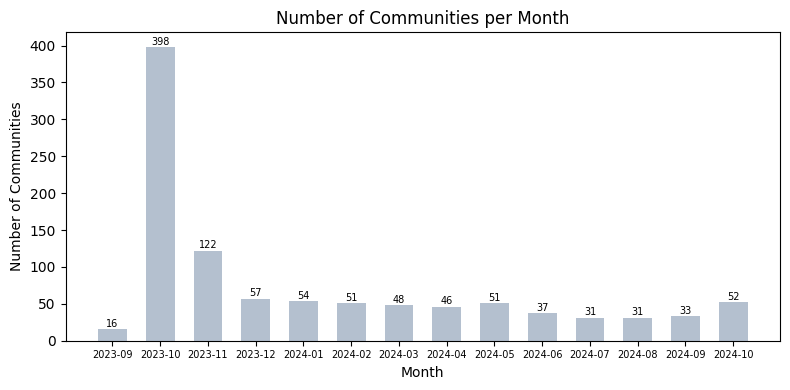

In [ ]:
months = stats_df.index

plt.figure(figsize=(8, 4))
bar_width = 0.6  # Thicker bars

# Plot the bar chart.
bars = plt.bar(x, stats_df['num_communities'], width=bar_width, color='#b4c0cf')
plt.title("Number of Communities per Month")
plt.xlabel("Month")
plt.ylabel("Number of Communities")
plt.xticks(x, months, rotation=0, fontsize=7)

# Annotate each bar with its value.
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{int(height)}',
             ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()

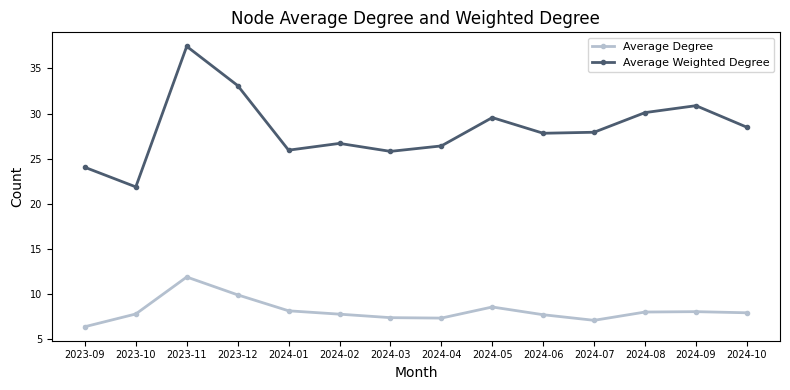

In [ ]:
# Convert month index to strings and create numeric positions.
months = stats_df.index

plt.figure(figsize=(8, 4))
plt.plot(x, stats_df['avg_degree'], marker='.', label='Average Degree', linewidth=2, color='#b4c0cf')
plt.plot(x, stats_df['avg_weighted_degree'], marker='.', label='Average Weighted Degree', linewidth=2, color = '#4c5c70')
plt.title("Node Average Degree and Weighted Degree")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(x, months, rotation=0, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

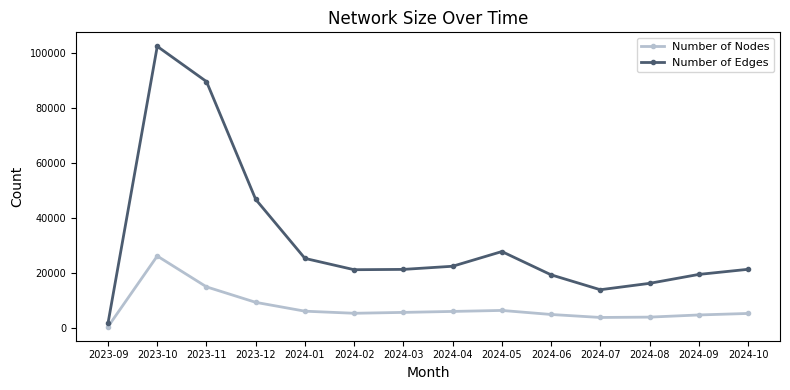

In [ ]:
# Convert month index to strings and create numeric positions.
months = stats_df.index

plt.figure(figsize=(8, 4))
plt.plot(x, stats_df['num_nodes'], marker='.', label='Number of Nodes', linewidth=2, color='#b4c0cf')
plt.plot(x, stats_df['num_edges'], marker='.', label='Number of Edges', linewidth=2, color = '#4c5c70')
plt.title("Network Size Over Time")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(x, months, rotation=0, fontsize=7)
plt.yticks(fontsize=7)
plt.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

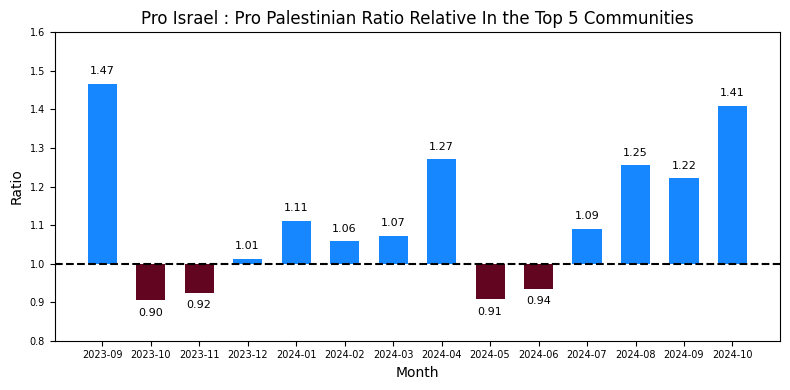

In [ ]:
import matplotlib.ticker as ticker
# Compute delta: difference from 1 (i.e. ratio - 1)
ratios = stats_df['avg_ratio_pro_israeli_to_pro_palestinian']
delta = ratios - 1

plt.figure(figsize=(8, 4))

# Color bars: blue (#1787ff) if delta >= 0, red (#610520) otherwise.
colors = ['#1787ff' if d >= 0 else '#610520' for d in delta]

# Plot the bars with thicker width.
bars = plt.bar(months, delta, color=colors, width=0.6)

# Draw a horizontal line at y = 0 (which corresponds to a ratio of 1).
plt.axhline(0, color='black', linestyle='--')

plt.title("Pro Israel : Pro Palestinian Ratio Relative In the Top 5 Communities")
plt.xlabel("Month")
plt.ylabel("Ratio")  # Now the y-axis represents the actual ratio.
plt.xticks(rotation=0, fontsize=7)
plt.yticks(fontsize=7)

# Set y-axis limits from -0.2 to 0.5.
plt.ylim(-0.2, 0.6)

# Custom formatter to add 1 to the displayed tick value.
def add_one_formatter(x, pos):
    return f"{x + 1:.1f}"

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(add_one_formatter))

# Annotate each bar with the actual ratio value.
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height >= 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{ratios.iloc[i]:.2f}",
                 ha='center', va='bottom', fontsize=8)
    else:
        plt.text(bar.get_x() + bar.get_width()/2, height - 0.02, f"{ratios.iloc[i]:.2f}",
                 ha='center', va='top', fontsize=8)

plt.tight_layout()
plt.show()